# Generative AI Use Case: Summarize Dialogue

**1 - Set up Kernel and Required Dependencies**

In [1]:
%pip install --upgrade pip
%pip install --disable-pip-version-check \
    torch==1.13.1 \
    torchdata==0.5.1 --quiet

%pip install \
    transformers==4.27.2 \
    datasets==2.11.0  --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.2.1+cu121 requires torch==2.2.1, but you have torch 1.13.1 which is incompatible.
torchtext 0.17.1 requires torch

**Load the datasets, Large Language Model (LLM), tokenizer, and configurator.**

In [2]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer
from transformers import GenerationConfig

**2 - Summarize Dialogue without Prompt Engineering**

Let's upload some simple dialogues from the DialogSum Hugging Face dataset. This dataset contains 10,000+ dialogues with the corresponding manually labeled summaries and topics.

In [3]:
huggingface_dataset_name = "knkarthick/dialogsum"

dataset = load_dataset(huggingface_dataset_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/knkarthick___csv/knkarthick--dialogsum-cd36827d3490488d/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
example_indices = [40, 200]

dash_line = '-'.join('' for x in range(100))

for i, index in enumerate(example_indices):
    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print('INPUT DIALOGUE:')
    print(dataset['test'][index]['dialogue'])
    print(dash_line)
    print('BASELINE HUMAN SUMMARY:')
    print(dataset['test'][index]['summary'])
    print(dash_line)
    print()

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT DIALOGUE:
#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.
---------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Exa

---> Specifying the Model Name:

model_name = 'google/flan-t5-base' Specifies the name or identifier of the pre-trained sequence-to-sequence language model. In this case, the model is identified by the name 'google/flan-t5-base'. Loading the Pre-trained Model:

model = AutoModelForSeq2SeqLM.from_pretrained(model_name) Uses the AutoModelForSeq2SeqLM class from the Transformers library to load the pre-trained sequence-to-sequence language model. The from_pretrained method loads the model weights and configuration from the Hugging Face Model Hub

In [5]:
model_name='google/flan-t5-base'
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

---> Loading the Pre-trained Tokenizer: tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True) Uses the AutoTokenizer class from the Transformers library to load the pre-trained tokenizer associated with the sequence-to-sequence language model specified by model_name. The from_pretrained method loads the tokenizer's vocabulary and configuration from the Hugging Face Model Hub. The use_fast=True argument indicates that the fast tokenizer implementation should be used if available. Fast tokenizers are optimized for speed. Now, the tokenizer variable holds an instance of the pre-trained tokenizer, which can be used to tokenize input text, convert it into model input format, and decode model outputs into human-readable text. The specific tokenizer is determined by the pre-trained model named 'google/flan-t5-base'.

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

---> Encoding the Sentence:

sentence_encoded = tokenizer(sentence, return_tensors='pt') Uses the tokenizer to encode the input sentence. The return_tensors='pt' argument specifies that the output should be in PyTorch tensor format. Decoding the Sentence:

sentence_decoded = tokenizer.decode(sentence_encoded["input_ids"][0], skip_special_tokens=True) Decodes the encoded sentence back into human-readable text. The skip_special_tokens=True argument indicates that special tokens (such as padding or [CLS]/[SEP] tokens) should be skipped during decoding. Printing Encoded and Decoded Sentences:

Prints the encoded representation of the sentence (sentence_encoded["input_ids"][0]), which is a tensor.

Prints the decoded version of the sentence (sentence_decoded), which should match the original sentence.

In [7]:
sentence = "What time is it, Tom?"

sentence_encoded = tokenizer(sentence, return_tensors='pt')

sentence_decoded = tokenizer.decode(
        sentence_encoded["input_ids"][0],
        skip_special_tokens=True
    )

print('ENCODED SENTENCE:')
print(sentence_encoded["input_ids"][0])
print('\nDECODED SENTENCE:')
print(sentence_decoded)

ENCODED SENTENCE:
tensor([ 363,   97,   19,   34,    6, 3059,   58,    1])

DECODED SENTENCE:
What time is it, Tom?


---> Looping through Example Indices:

for i, index in enumerate(example_indices): Iterates through the specified example indices. Extracting Dialogue and Summary:

dialogue = dataset['test'][index]['dialogue'] summary = dataset['test'][index]['summary'] Retrieves the dialogue and baseline human summary for the current example from the dataset. Encoding the Dialogue:

inputs = tokenizer(dialogue, return_tensors='pt') Uses the tokenizer to encode the dialogue. The encoded input is returned as a PyTorch tensor. Generating Model Output:

output = tokenizer.decode(model.generate(inputs["input_ids"], max_new_tokens=50)[0], skip_special_tokens=True) Uses the pre-trained model to generate a summary based on the encoded input. The max_new_tokens=50 argument limits the maximum number of tokens in the generated output. The generated output is then decoded into human-readable text. Printing Information:

Prints information about the current example, including the input prompt (dialogue), baseline human summary, and the generated summary without prompt engineering.

In [9]:
for i, index in enumerate(example_indices):
    dialogue = dataset['test'][index]['dialogue']
    summary = dataset['test'][index]['summary']

    inputs = tokenizer(dialogue, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"],
            max_new_tokens=50,
        )[0],
        skip_special_tokens=True
    )

    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{dialogue}')
    print(dash_line)
    print(f'BASELINE HUMAN SUMMARY:\n{summary}')
    print(dash_line)
    print(f'MODEL GENERATION - WITHOUT PROMPT ENGINEERING:\n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:
#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.
---------------------------------------------------------------------------------------------------
MODEL GENERATION - WITHOUT PROMPT ENGINEERING:
Person1: It's ten to nine.

-------------------------------

--- Evaluation Function:

A placeholder evaluate_summary function is added.
Evaluation Scores List: A list evaluation_scores is created to store the evaluation scores for each example.

Evaluation within the Loop: After generating each summary, the model's output is evaluated using the evaluate_summary function, and the score is appended to the evaluation_scores list.

Plotting Evaluation Scores: Matplotlib is used to create a bar plot showing the evaluation scores for each example.

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:

    Summarize the following conversation.

    #Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.

    Summary:
    
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.
---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:
The train

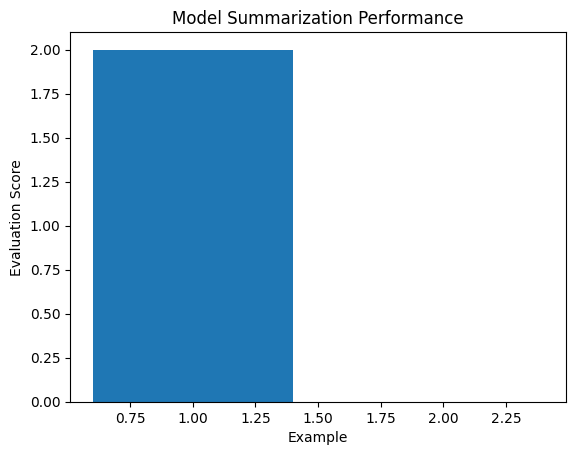

In [10]:
import matplotlib.pyplot as plt

# Placeholder function for evaluation
def evaluate_summary(generated_summary, human_summary):
    # This is just a placeholder. Replace it with your actual evaluation logic.
    # For example, you might use ROUGE or BLEU scores for text summarization evaluation.
    return len(set(generated_summary.lower().split()) & set(human_summary.lower().split()))

# Assuming you have a list to store evaluation scores for each example
evaluation_scores = []

for i, index in enumerate(example_indices):
    # Extract dialogue and summary from the dataset
    dialogue = dataset['test'][index]['dialogue']
    summary = dataset['test'][index]['summary']

    # Construct the prompt for summarization
    prompt = f"""
    Summarize the following conversation.

    {dialogue}

    Summary:
    """

    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors='pt')

    # Generate a summary using the pre-trained model
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"],
            max_new_tokens=50,
        )[0],
        skip_special_tokens=True
    )

    # Evaluate the generated summary using the placeholder function
    evaluation_score = evaluate_summary(output, summary)
    evaluation_scores.append(evaluation_score)
# Print information for each example
    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{prompt}')
    print(dash_line)
    print(f'BASELINE HUMAN SUMMARY:\n{summary}')
    print(dash_line)
    print(f'MODEL GENERATION - ZERO SHOT:\n{output}\n')

# Plotting the evaluation scores
plt.bar(range(1, len(evaluation_scores) + 1), evaluation_scores)
plt.xlabel('Example')
plt.ylabel('Evaluation Score')
plt.title('Model Summarization Performance')
plt.show()

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:

    Dialogue:

    #Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.

    What was going on?
    
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.

---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:
Tom is late for the train.

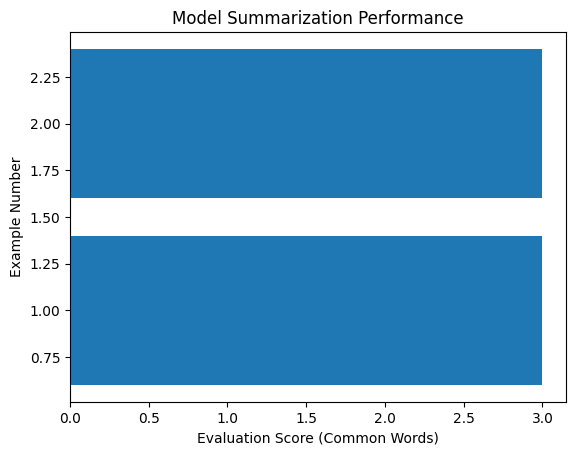

In [19]:
import matplotlib.pyplot as plt

# Placeholder function for evaluation (counting common words)
def evaluate_summary(generated_summary, human_summary):
    return len(set(generated_summary.lower().split()) & set(human_summary.lower().split()))

# Lists to store information for visualization
example_numbers = []
evaluation_scores = []

for i, index in enumerate(example_indices):
    # Extract dialogue and summary from the dataset
    dialogue = dataset['test'][index]['dialogue']
    summary = dataset['test'][index]['summary']

    # Construct the prompt for summarization
    prompt = f"""
    Dialogue:

    {dialogue}

    What was going on?
    """

    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors='pt')

    # Generate a summary using the pre-trained model
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"],
            max_new_tokens=50,
        )[0],
        skip_special_tokens=True
    )

    # Evaluate the generated summary using the placeholder function
    evaluation_score = evaluate_summary(output, summary)

    # Store information for visualization
    example_numbers.append(i + 1)
    evaluation_scores.append(evaluation_score)

    # Print information for each example
    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{prompt}')
    print(dash_line)
    print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
    print(dash_line)
    print(f'MODEL GENERATION - ZERO SHOT:\n{output}\n')

# Plotting the evaluation scores
plt.barh(example_numbers, evaluation_scores)
plt.xlabel('Evaluation Score (Common Words)')
plt.ylabel('Example Number')
plt.title('Model Summarization Performance')
plt.show()

#3 - Summarize Dialogue with an Instruction Prompt


Prompt engineering is an important concept in using foundation models for text generation. You can check out this blog from Amazon Science for a quick introduction to prompt engineering.

**3.1 - Zero Shot Inference with an Instruction Prompt**

In order to instruct the model to perform a task - summarize a dialogue - you can take the dialogue and convert it into an instruction prompt. This is often called zero shot inference.

In [12]:
for i, index in enumerate(example_indices):
    dialogue = dataset['test'][index]['dialogue']
    summary = dataset['test'][index]['summary']

    prompt = f"""
what is happening in this conversation.

{dialogue}

Summary:
    """

    # Input constructed prompt instead of the dialogue.
    inputs = tokenizer(prompt, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"],
            max_new_tokens=50,
        )[0],
        skip_special_tokens=True
    )

    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{prompt}')
    print(dash_line)
    print(f'BASELINE HUMAN SUMMARY:\n{summary}')
    print(dash_line)
    print(f'MODEL GENERATION - ZERO SHOT:\n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:

what is happening in this conversation.

#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.

Summary:
    
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.
---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:
Tom is late for wor

#3.2 - Zero Shot Inference with the Prompt Template from FLAN-T5

Let's use a slightly different prompt. FLAN-T5 has many prompt templates that are published for certain tasks here. In the following code, you will use one of the pre-built FLAN-T5 prompts:

In [14]:
for i, index in enumerate(example_indices):
    dialogue = dataset['test'][index]['dialogue']
    summary = dataset['test'][index]['summary']

    prompt = f"""
Dialogue:

{dialogue}

what is happening in this conversation?
"""

    inputs = tokenizer(prompt, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"],
            max_new_tokens=50,
        )[0],
        skip_special_tokens=True
    )

    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{prompt}')
    print(dash_line)
    print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
    print(dash_line)
    print(f'MODEL GENERATION - ZERO SHOT:\n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Dialogue:

#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.

what is happening in this conversation?

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.

---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:
Tom is late for work.

Notice that this prompt from FLAN-T5 did help a bit, but still struggles to pick up on the nuance of the conversation. This is what you will try to solve with the few shot inferencing.

#4 - Summarize Dialogue with One Shot and Few Shot Inference

One shot and few shot inference are the practices of providing an LLM with either one or more full examples of prompt-response pairs that match your task - before your actual prompt that you want completed. This is called "in-context learning" and puts your model into a state that understands your specific task. You can read more about it in this blog from HuggingFace.

**4.1 - One Shot Inference**

Let's build a function that takes a list of example_indices_full, generates a prompt with full examples, then at the end appends the prompt which you want the model to complete (example_index_to_summarize).

In [15]:
def make_prompt(example_indices_full, example_index_to_summarize):
    prompt = ''
    for index in example_indices_full:
        dialogue = dataset['test'][index]['dialogue']
        summary = dataset['test'][index]['summary']

        # The stop sequence '{summary}\n\n\n' is important for FLAN-T5. Other models may have their own preferred stop sequence.
        prompt += f"""
Dialogue:

{dialogue}

What was going on?
{summary}


"""

    dialogue = dataset['test'][example_index_to_summarize]['dialogue']

    prompt += f"""
Dialogue:

{dialogue}

What was going on?
"""

    return prompt

In [16]:
example_indices_full = [40]
example_index_to_summarize = 200

one_shot_prompt = make_prompt(example_indices_full, example_index_to_summarize)

print(one_shot_prompt)


Dialogue:

#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.

What was going on?
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.



Dialogue:

#Person1#: Have you considered upgrading your system?
#Person2#: Yes, but I'm not sure what exactly I would need.
#Person1#: You could consider adding a painting program to your software. It would allow you to make up your own flyers and banners for advertising.
#Person2#: That would be a definite bonus.
#Person1#: You might also want to upgrade your hardware because it is pretty outdated now.
#Person2#: How can we do that?
#Person1#: You'd probably need a faster processor, to begin with. And you also ne

In [17]:
summary = dataset['test'][example_index_to_summarize]['summary']

inputs = tokenizer(one_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=50,
    )[0],
    skip_special_tokens=True
)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - ONE SHOT:\n{output}')

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.

---------------------------------------------------------------------------------------------------
MODEL GENERATION - ONE SHOT:
#Person1 wants to upgrade his system. #Person2 wants to add a painting program to his software. #Person1 wants to add a CD-ROM drive.


**4.2 - Few Shot Inference**

In [18]:
example_indices_full = [40, 80, 120]
example_index_to_summarize = 200

few_shot_prompt = make_prompt(example_indices_full, example_index_to_summarize)

print(few_shot_prompt)


Dialogue:

#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.

What was going on?
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.



Dialogue:

#Person1#: May, do you mind helping me prepare for the picnic?
#Person2#: Sure. Have you checked the weather report?
#Person1#: Yes. It says it will be sunny all day. No sign of rain at all. This is your father's favorite sausage. Sandwiches for you and Daniel.
#Person2#: No, thanks Mom. I'd like some toast and chicken wings.
#Person1#: Okay. Please take some fruit salad and crackers for me.
#Person2#: Done. Oh, don't forget to take napkins disposable plates, cups and picnic blanket.
#Person1#: All set. 

#Fine-Tune a Generative AI Model for Dialogue Summarization

In [21]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.9 MB/s eta 0:00:00


In [22]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
import torch
import time
import evaluate
import pandas as pd
import numpy as np

In [23]:
huggingface_dataset_name = "knkarthick/dialogsum"

dataset = load_dataset(huggingface_dataset_name)

dataset

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
})

In [24]:
model_name='google/flan-t5-base'

original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)

It is possible to pull out the number of model parameters and find out how many of them are trainable. The following function can be used to do that, at this stage, you do not need to go into details of it.

In [25]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(original_model))

trainable model parameters: 247577856
all model parameters: 247577856
percentage of trainable model parameters: 100.00%


**1.3 - Test the Model with Zero Shot Inferencing**

Test the model with the zero shot inferencing. You can see that the model struggles to summarize the dialogue compared to the baseline summary, but it does pull out some important information from the text which indicates the model can be fine-tuned to the task at hand.

In [27]:
index = 200

dialogue = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

{dialogue}

Summary:
"""

inputs = tokenizer(prompt, return_tensors='pt')
output = tokenizer.decode(
    original_model.generate(
        inputs["input_ids"],
        max_new_tokens=200,
    )[0],
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Summarize the following conversation.

#Person1#: Have you considered upgrading your system?
#Person2#: Yes, but I'm not sure what exactly I would need.
#Person1#: You could consider adding a painting program to your software. It would allow you to make up your own flyers and banners for advertising.
#Person2#: That would be a definite bonus.
#Person1#: You might also want to upgrade your hardware because it is pretty outdated now.
#Person2#: How can we do that?
#Person1#: You'd probably need a faster processor, to begin with. And you also need a more powerful hard disc, more memory and a faster modem. Do you have a CD-ROM drive?
#Person2#: No.
#Person1#: Then you might want to add a CD-ROM drive too, because most new software programs are coming out on Cds.
#Person2#: That sounds great. Thanks.

Summary:

-------------------------------------------------------------------

In [29]:
def tokenize_function(example):
    """
    Tokenizes dialogues and summaries separately for input into a neural network.
    Processes the data in batches for efficiency.

    Parameters:
        example (dict): A batch from the dataset containing 'dialogue' and 'summary'.

    Returns:
        dict: A dictionary with tokenized 'input_ids' for dialogues and 'labels' for summaries.
    """
    start_prompt = 'Summarize the following conversation.\n\n'
    end_prompt = '\n\nSummary: '

    # Creating prompts for each dialogue
    prompts = [start_prompt + dialogue + end_prompt for dialogue in example["dialogue"]]

    # Tokenizing dialogues with the prompts
    tokenized_dialogues = tokenizer(prompts, padding="max_length", truncation=True)

    # Tokenizing summaries
    tokenized_summaries = tokenizer(example["summary"], padding="max_length", truncation=True)

    # Assigning tokenized results to input_ids and labels
    example['input_ids'] = tokenized_dialogues['input_ids']
    example['labels'] = tokenized_summaries['input_ids']

    return example

# Assuming `dataset` is a HuggingFace dataset with splits
tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=['id', 'topic', 'dialogue', 'summary'])


Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [30]:
tokenized_datasets = tokenized_datasets.filter(lambda example, index: index % 100 == 0, with_indices=True)

Filter:   0%|          | 0/12460 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

In [31]:
print(f"Shapes of the datasets:")
print(f"Training: {tokenized_datasets['train'].shape}")
print(f"Validation: {tokenized_datasets['validation'].shape}")
print(f"Test: {tokenized_datasets['test'].shape}")

print(tokenized_datasets)

Shapes of the datasets:
Training: (125, 2)
Validation: (5, 2)
Test: (15, 2)
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 125
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 15
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 5
    })
})


**2.2 - Fine-Tune the Model with the Preprocessed Dataset**

Now utilize the built-in Hugging Face Trainer class (see the documentation here). Pass the preprocessed dataset with reference to the original model. Other training parameters are found experimentally and there is no need to go into details about those at the moment.

In [32]:
output_dir = f'./dialogue-summary-training-{str(int(time.time()))}'

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=1e-5,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_steps=1,
    max_steps=1
)

trainer = Trainer(
    model=original_model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation']
)

In [33]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
1,49.500000


TrainOutput(global_step=1, training_loss=49.5, metrics={'train_runtime': 5.8394, 'train_samples_per_second': 1.37, 'train_steps_per_second': 0.171, 'total_flos': 5478058819584.0, 'train_loss': 49.5, 'epoch': 0.06})

In [35]:
!pip install sentencepiece
from transformers import T5Tokenizer
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset


data = load_dataset("knkarthick/dialogsum")

class DialogueSummarizationDataset(Dataset):
    def __init__(self, tokenizer, data, max_length=512, summary_max_length=150):
        self.tokenizer = tokenizer
        self.data = data
        self.max_length = max_length
        self.summary_max_length = summary_max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        inputs = self.tokenizer.encode_plus(
            row['dialogue'],
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_tensors="pt"
        )
        targets = self.tokenizer.encode_plus(
            row['summary'],
            max_length=self.summary_max_length,
            truncation=True,
            padding='max_length',
            return_tensors="pt"
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': targets['input_ids'].flatten()
        }

tokenizer = T5Tokenizer.from_pretrained('google/flan-t5-base')

df = pd.DataFrame(data['train'])


train_data = df.sample(frac=0.8, random_state=42)
eval_data = df.drop(train_data.index)


train_dataset = DialogueSummarizationDataset(tokenizer, train_data)
eval_dataset = DialogueSummarizationDataset(tokenizer, eval_data)


train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=4, shuffle=False)

  0%|          | 0/3 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (656 > 512). Running this sequence through the model will result in indexing errors


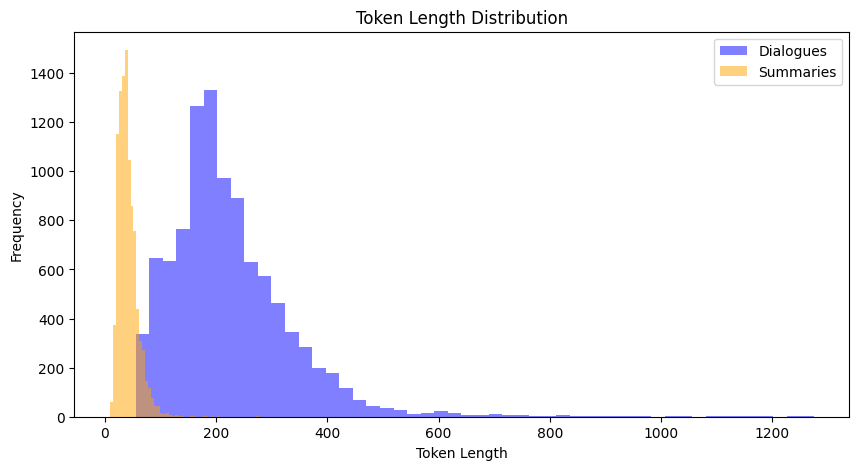

In [36]:
import matplotlib.pyplot as plt

# Visualize the token lengths of dialogues and summaries
dialogue_lengths = [len(tokenizer.encode(dialogue)) for dialogue in train_data['dialogue']]
summary_lengths = [len(tokenizer.encode(summary)) for summary in train_data['summary']]

# Plot histograms
plt.figure(figsize=(10, 5))
plt.hist(dialogue_lengths, bins=50, alpha=0.5, color='blue', label='Dialogues')
plt.hist(summary_lengths, bins=50, alpha=0.5, color='orange', label='Summaries')
plt.title('Token Length Distribution')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [37]:
!pip install sentencepiece transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.utils.data import Dataset, DataLoader
from transformers import Trainer, TrainingArguments
from datasets import load_dataset

# Load the dataset
data = load_dataset("knkarthick/dialogsum")

class DialogueSummarizationDataset(Dataset):
    def __init__(self, tokenizer, data, max_length=512, summary_max_length=150):
        self.tokenizer = tokenizer
        self.data = data
        self.max_length = max_length
        self.summary_max_length = summary_max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        input_text = "summarize: " + row['dialogue']
        target_text = row['summary']

        # Tokenize input and output
        input_encoding = self.tokenizer(
            input_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        target_encoding = self.tokenizer(
            target_text,
            max_length=self.summary_max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        return {
            'input_ids': input_encoding['input_ids'].flatten(),
            'attention_mask': input_encoding['attention_mask'].flatten(),
            'labels': target_encoding['input_ids'].flatten()
        }

# Initialize the tokenizer and model
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base')

# Convert to Pandas DataFrame
df = pd.DataFrame(data['train'])  # Assuming you want to work with the 'train' split

# Split the data into training and evaluation sets
train_data = df.sample(frac=0.8, random_state=42)
eval_data = df.drop(train_data.index)

train_dataset = DialogueSummarizationDataset(tokenizer, train_data)
eval_dataset = DialogueSummarizationDataset(tokenizer, eval_data)


def generate_summary(model, tokenizer, text, max_length=150):

    input_ids = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=max_length, truncation=True)

    device = next(model.parameters()).device

    input_ids = input_ids.to(device)

    summary_ids = model.generate(input_ids, max_length=max_length, length_penalty=2.0, num_beams=4, early_stopping=True)


    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary

  0%|          | 0/3 [00:00<?, ?it/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

The below code segment utilizes the matplotlib library to create histograms visualizing the distribution of token lengths for dialogues and summaries in a training dataset.

It calculates the token lengths using the T5 tokenizer, then generates side-by-side histograms with 50 bins for both dialogue and summary lengths. The blue histogram represents dialogue lengths, and the orange histogram represents summary lengths.

The resulting visualizations provide insights into the length characteristics of the dataset, aiding in understanding the distribution of token lengths for dialogues and summaries.

Token indices sequence length is longer than the specified maximum sequence length for this model (656 > 512). Running this sequence through the model will result in indexing errors


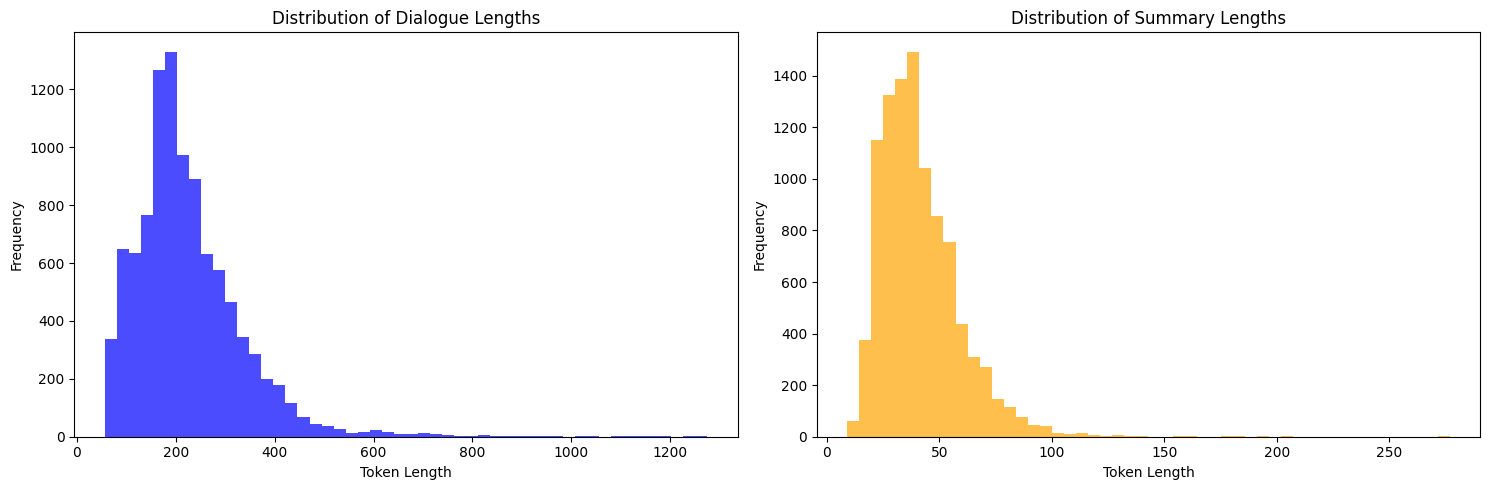

In [38]:
import matplotlib.pyplot as plt


dialogue_lengths = [len(tokenizer.encode(dialogue)) for dialogue in train_data['dialogue']]
summary_lengths = [len(tokenizer.encode(summary)) for summary in train_data['summary']]

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(dialogue_lengths, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Dialogue Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')


plt.subplot(1, 2, 2)
plt.hist(summary_lengths, bins=50, color='orange', alpha=0.7)
plt.title('Distribution of Summary Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()